# Dry Waste Classification Using Convolutional Neural Networks.


---

---
 


#Preparing COLAB:

---

In [165]:
import subprocess
 
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)
 
if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 10.1


In [166]:
!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
import torch
print("Torch version:", torch.__version__)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Torch version: 1.7.1+cu101


In [167]:
#Checking for GPU:
batch_size=512
from torch import cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [168]:
!pip install -Uqq fastbook 

In [169]:
import fastbook
fastbook.setup_book() 

#Preparing Dataset:

---

In [170]:
!unzip /content/gdrive/MyDrive/GarbageClassification/garbage.zip

Archive:  /content/gdrive/MyDrive/GarbageClassification/garbage.zip
replace __MACOSX/._Garbage classification? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [171]:
import os
!mkdir data/
!rm -rf data/
!rm -rf data/train
!rm -rf data/test
!rm -rf data/val
!mkdir data/
!mkdir data/train
!mkdir data/test
!mkdir data/val

mkdir: cannot create directory ‘data/’: File exists


In [197]:
import pandas as pd 
df = pd.read_csv('/content/gdrive/MyDrive/GarbageClassification/garbage.csv', names=['FilePath', 'Target', 'Labels'], skiprows=1)
df

,FilePath,Target,Labels
0,/glass/glass454.jpg,0,glass
1,/glass/glass69.jpg,0,glass
2,/glass/glass385.jpg,0,glass
3,/glass/glass452.jpg,0,glass
4,/glass/glass266.jpg,0,glass
...,...,...,...
2385,/metal/metal103.jpg,4,metal
2386,/metal/metal210.jpg,4,metal
2387,/metal/metal122.jpg,4,metal
2388,/metal/metal361.jpg,4,metal


In [198]:
df['FilePath'] = '/content/Garbage classification' + df.FilePath
df

,FilePath,Target,Labels
0,/content/Garbage classification/glass/glass454.jpg,0,glass
1,/content/Garbage classification/glass/glass69.jpg,0,glass
2,/content/Garbage classification/glass/glass385.jpg,0,glass
3,/content/Garbage classification/glass/glass452.jpg,0,glass
4,/content/Garbage classification/glass/glass266.jpg,0,glass
...,...,...,...
2385,/content/Garbage classification/metal/metal103.jpg,4,metal
2386,/content/Garbage classification/metal/metal210.jpg,4,metal
2387,/content/Garbage classification/metal/metal122.jpg,4,metal
2388,/content/Garbage classification/metal/metal361.jpg,4,metal


In [200]:
Names = ['glass', 'paper', 'cardboard', 'plastic', 'metal']

In [201]:
n_classes = len(Names)
print('Number of classes:',n_classes)

Number of classes: 5


In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, _, _ = train_test_split(df, df['Labels'],stratify=df['Labels'], test_size=0.3)
X_test, X_val, _, _ = train_test_split(X_test, X_test['Labels'], stratify=X_test['Labels'], test_size=0.5)

In [ ]:
X_train['Type'] = 'train'
X_test['Type'] = 'test'
X_val['Type'] = 'val'
df = pd.concat([X_train,X_test, X_val])

In [179]:
df

,FilePath,Target,Labels,Type
1350,/content/Garbage classification/cardboard/cardboard341.jpg,2,cardboard,train
1111,/content/Garbage classification/cardboard/cardboard114.jpg,2,cardboard,train
303,/content/Garbage classification/glass/glass144.jpg,0,glass,train
324,/content/Garbage classification/glass/glass369.jpg,0,glass,train
441,/content/Garbage classification/glass/glass40.jpg,0,glass,train
...,...,...,...,...
1761,/content/Garbage classification/plastic/plastic341.jpg,3,plastic,val
1228,/content/Garbage classification/cardboard/cardboard67.jpg,2,cardboard,val
2363,/content/Garbage classification/metal/metal256.jpg,4,metal,val
1695,/content/Garbage classification/plastic/plastic471.jpg,3,plastic,val


In [180]:
for name in Names:
  os.system(f"mkdir data/train/'{name}'") 
  os.system(f"mkdir data/test/'{name}'")
  os.system(f"mkdir data/val/'{name}'")

In [181]:
from shutil import copyfile
for i,row in df.iterrows():
    section = row['Type']
    ipath = row['FilePath']
    opath = ipath.replace(f"Garbage classification/",f"data/{section}/")
    copyfile(ipath, opath)

In [182]:
traindir = '/content/data/train'
testdir = '/content/data/test'
valdir = '/content/data/val'

# Image Transformations:

--- 



In [183]:
#Function to define Image Transformations:
from torchvision import transforms
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=25),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
} 

In [184]:
from torchvision import datasets
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['val'])
} 

In [185]:
def imshow_tensor(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image 

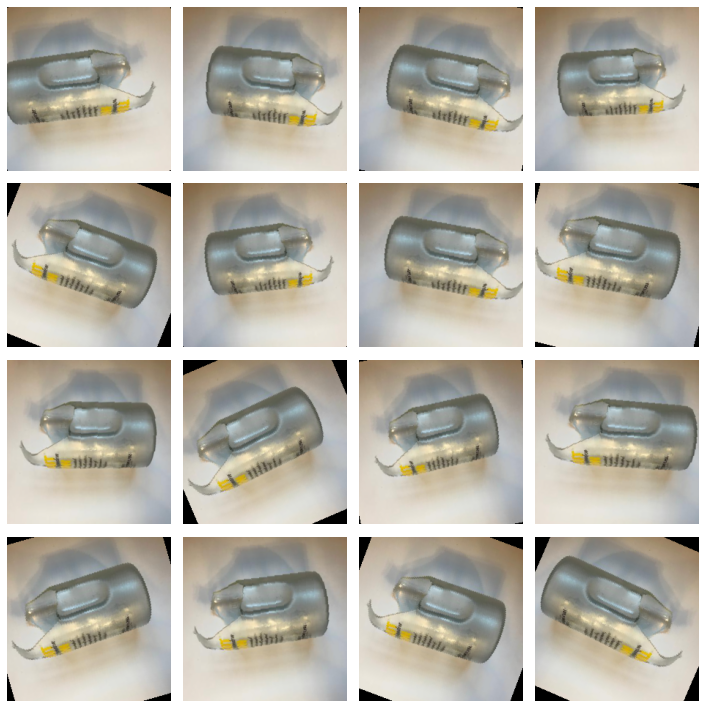

In [204]:
#Image Transform:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
ex_img = Image.open('/content/data/train/glass/glass102.jpg')
t = image_transforms['train']
plt.figure(figsize=(10,10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)
plt.tight_layout()

#Setting Up Dataloaders:

---



In [205]:
#Dataloaders:
from torch.utils.data import DataLoader
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'val':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=10),
    'val': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=10)
} 

In [206]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape 

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

#Model: ResNet50 Feature Extraction.

In [ ]:
#Model:
from torchvision import models
model = models.resnet50(pretrained=True)

In [ ]:
print(model)

In [ ]:
for param in model.parameters():
    param.requires_grad = False 

In [ ]:
#Custom classifier:
import torch.nn as nn
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

In [ ]:
model.fc 

In [ ]:
if train_on_gpu:
    model = model.to('cuda') 

In [ ]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10] 

In [ ]:
#Loss function and Optimizer:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape) 

# Training Model:

In [ ]:
#Function to train Model:
from timeit import default_timer as timer
def train(model,criterion,optimizer,train_loader, valid_loader, n_epochs=20, print_every=1):
  history = []

  for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0
    valid_loss = 0.0
    valid_acc = 0

    model.train()
    start = timer()

    for i, (data, target) in enumerate(train_loader):
      if train_on_gpu: 
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(target.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      train_acc += accuracy.item() * data.size(0)
    
    else:
      with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
          if train_on_gpu:
            data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
          _, pred = torch.max(output, dim=1)
          correct_tensor = pred.eq(target.data.view_as(pred))
          accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
          valid_acc += accuracy.item()*data.size(0)

  train_loss = train_loss / len(train_loader.dataset)
  train_acc = train_acc / len(train_loader.dataset)
  valid_loss = valid_loss / len(valid_loader.dataset)
  valid_acc = valid_acc / len(valid_loader.dataset)
  history.append([train_loss, train_acc, valid_loss, valid_acc])

  model.optimizer = optimizer
  total_time = timer() 
  history = pd.DataFrame(history,columns=['Train_loss', 'Train_acc', 'Val_loss', 'Val_ac'])

  return model, history

In [ ]:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], n_epochs=30)

In [ ]:
history 

#Predictions on a single image:



In [207]:
#Function to process an Image path into a Tensor:
def process_image(image_path):

    image = Image.open(image_path)
    img = image.resize((256, 256))

    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))
    img = np.array(img).transpose((2, 0, 1)) / 256
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [208]:
#Function to make predictions on a single image:
def predict(image_path, model, topk=3):
    real_class = image_path.split('/')[-2]

    img_tensor = process_image(image_path)

    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        out = model(img_tensor)
        ps = torch.exp(out)

        #Top 3 predictions
        topk, topclass = ps.topk(topk, dim=1)
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [209]:
img_path = '/content/data/test/metal/metal136.jpg'
img, top_p, top_classes, real_class = predict(img_path, model,topk=3)

In [210]:
top_p, top_classes

(array([0.94373995, 0.03715513, 0.01862367], dtype=float32),
 ['metal', 'plastic', 'glass'])

In [211]:
#Function to display Image and Predictions:
def display_prediction(image_path, model, topk):
    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index=classes)
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    #Bar plot
    result.sort_values('p')['p'].plot.barh(color='#2e4d7d', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

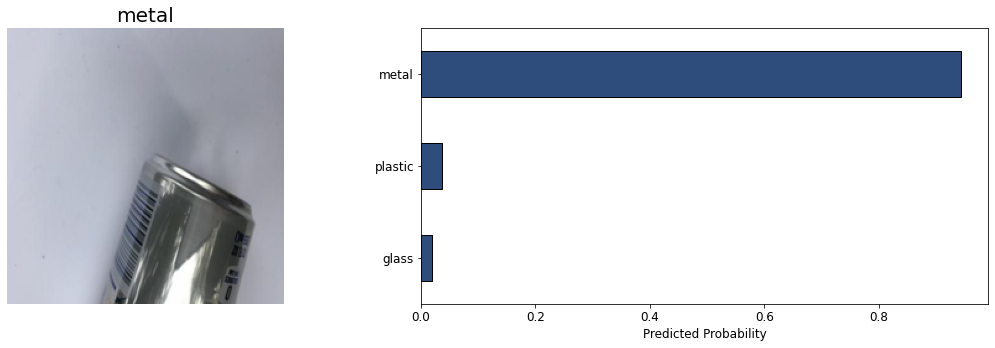

In [212]:
display_prediction(img_path, model, topk=3)

#Evaluation of model and results:

In [213]:
#Function to calculate accuracy of Top N predictions:
def accuracy(output, target, topk=(1, )):
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [214]:
#Function to evaluate model: 
def evaluate(model, test_loader, criterion, topk=(1, 2, 3)):
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
          
            for pred, true in zip(out, targets):
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

criterion = nn.NLLLoss()

In [215]:
#Function to display Confusion Matrix:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt 

In [216]:
results, confusion_matrix = evaluate(model, dataloaders['test'], criterion)

Confusion matrix, without normalization


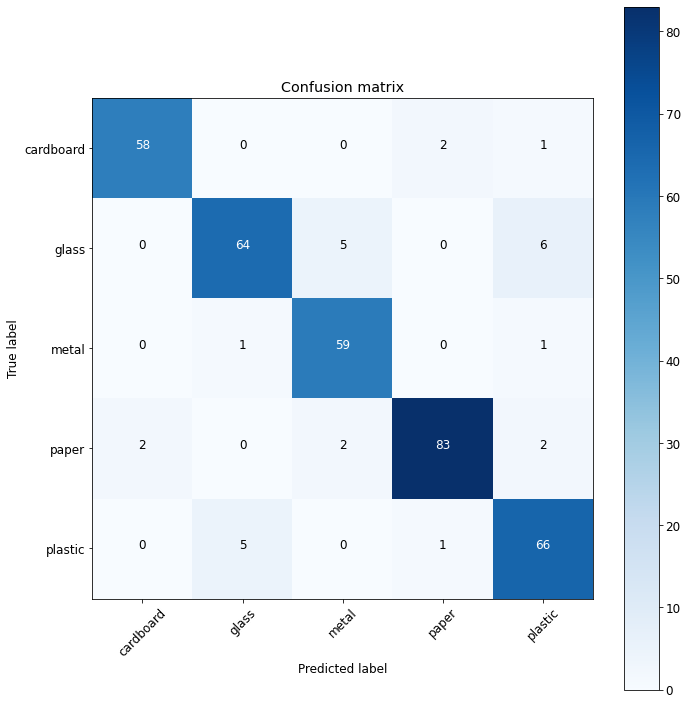

In [217]:
classnames = [model.idx_to_class[i] for i in range(0,n_classes)]
plt.figure(figsize=(10,10))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [218]:
#Results per class:
results

,class,top1,top2,top3,loss
0,cardboard,95.081967,100.000000,100.0,0.097707
1,glass,85.333333,98.666667,100.0,0.251472
2,metal,96.721311,100.000000,100.0,0.127538
3,paper,93.258427,98.876404,100.0,0.242939
4,plastic,91.666667,100.000000,100.0,0.196751


In [219]:
#Overall Accuracy:
print(f"Overall Accuracy:{(confusion_matrix.diag().sum()/confusion_matrix.sum())*100}%")

Overall Accuracy:92.17877197265625%
